In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import itertools
from matplotlib.ticker import MultipleLocator

%load_ext autoreload
%autoreload 2

In [2]:
import importlib
import igann

importlib.reload(igann)

from igann import IGANN

model = IGANN(task='regression', n_hid=10, interaction_detection_method='dt')

# 1. Create Synthetic Dataset

In [3]:
np.random.seed(1)
n_samples = 1000

# Kategorische Variablen
car_type = np.random.choice(["Sedan", "SUV", "Truck", "Electric", "Luxury"], size=n_samples)
age = np.random.randint(18, 80, size=n_samples)
age_effect = 1 + 0.002 * (age - 50) ** 2

# Numerische Variablen
mileage = np.random.uniform(5000, 200000, size=n_samples)
accidents = np.random.poisson(lam=0.5, size=n_samples)

interaction_effect = np.where(
    ((car_type == "Truck") & (mileage > 150000)), 1.4,  # Trucks mit hoher Mileage haben 40% höheren Schaden
    np.where(((car_type == "SUV") & (mileage > 100000)), 1.2,  # SUVs mit hoher Mileage haben 20% höheren Schaden
    np.where(((car_type == "Luxury") & (mileage > 120000)), 1.5,  # Luxury ab hoher Mileage haben 50% höheren Schaden
    np.where((car_type == "Electric"), 1.1,  # Electric haben 10% höheren Schaden
    1.0  # Default case
))))

# Schaden (in Euro) = Basiswert + Einfluss der Variablen + Interaktionseffekt
base_payout = 500  # Basiswert für alle Verträge
y = base_payout * interaction_effect + (mileage * 0.005) *interaction_effect * 0.5 + (accidents * 100) * 0.5  * age_effect + np.random.normal(loc=0, scale=100, size=n_samples)

# Daten in DataFrame speichern
X = pd.DataFrame({
    "carType": car_type,
    "age": age,
    "mileage": mileage,
    "accidents": accidents
})

# 2. Scale Data

In [4]:
# scale data
scaler = StandardScaler()
continuous_features = sorted(['mileage', 'accidents', 'age'])
X_num = scaler.fit_transform(X[continuous_features])
X_cat = X.drop(columns=continuous_features)
X = pd.concat([pd.DataFrame(X_num, columns=continuous_features), X_cat], axis=1)

y_mean = y.mean()
y_std = y.std()
y = (y - y_mean) / y_std

In [5]:
X

,accidents,age,mileage,carType
0,-0.730309,1.328774,-0.857577,Electric
1,0.710142,1.441216,-1.530140,Luxury
2,0.710142,-0.526506,-0.694661,Sedan
3,-0.730309,0.485465,0.516029,SUV
4,0.710142,-0.076741,-1.490394,Electric
...,...,...,...,...
995,0.710142,0.879009,0.089980,Sedan
996,-0.730309,-0.695168,0.184248,Sedan
997,-0.730309,-1.313595,0.213919,Luxury
998,-0.730309,-0.076741,0.109514,Luxury


# 3. Model Fitting

In [25]:
model.fit(X, y)

# 4. Plots

## 4.1 Univariate Plots

In [26]:
data_dict = model.get_shape_functions_as_dict()

### 4.1.1 Accidents

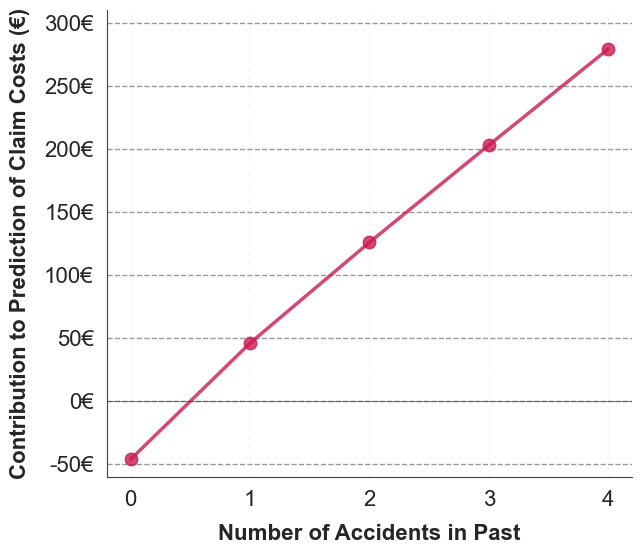

In [92]:
import matplotlib.ticker as mticker

accidents_data = next(item for item in data_dict if item["name"] == "accidents")

x_raw = accidents_data["x"]
y_raw = accidents_data["y"]

x_accident_mean = scaler.mean_[0]
x_accident_std = scaler.scale_[0]

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std #+ y_mean

with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    color = sns.color_palette("rocket_r", n_colors=1)[0]

    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)

    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, marker="o", markersize=9, label="Effect of Accidents on Claim Cost")

    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # labels and title
    ax.set_xlabel("Number of Accidents in Past", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')
    #ax.set_title("Accident History Effect", fontsize=22, fontweight="bold", pad=15)

    # ticks and grid
    ax.tick_params(axis='x', labelrotation=0, labelsize=16)  # Ensure no rotation
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Set X-axis to whole numbers only
    ax.set_xticks([0, 1, 2, 3, 4])

    # Set Y-axis limits
    ax.set_ylim(-60, 310)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Add legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=12, frameon=True, shadow=False, fancybox=True, borderpad=1)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()

In [29]:
y_rescaled

array([-45.98549 ,  46.066895, 125.859   , 202.91093 , 279.0272  ],
      dtype=float32)

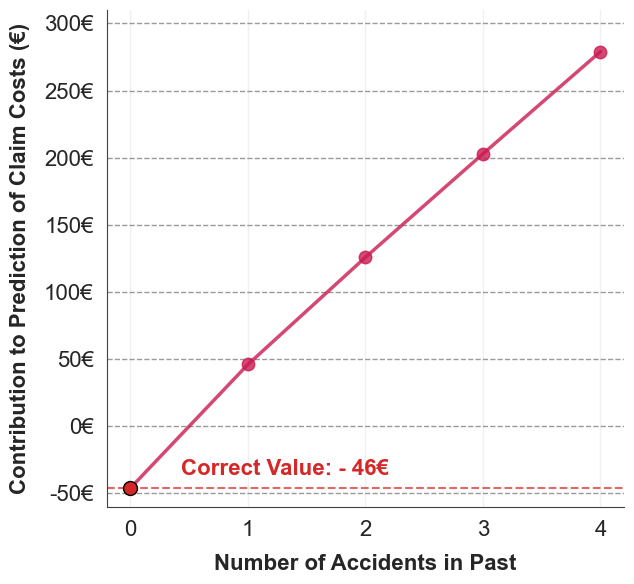

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Highlight-Farben
highlight_color = "#d62728"  # Rot für den korrekten Punkt
line_color = "#404040"

with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)
    color = sns.color_palette("rocket_r", n_colors=1)[0]

    fig, ax = plt.subplots(figsize=(6.5, 6), dpi=100)
    fig.patch.set_alpha(0)

    # Plot der Linie mit allen Punkten
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, marker="o", markersize=9, label="Effect of Accidents on Claim Cost")

    # Korrekte Antwort hervorheben (bei x=4, y=279€)
    ax.scatter(0, -46, color=highlight_color, s=100, zorder=3, edgecolor="black", label="Correct Value (-46€)")  # Punkt hervorheben
    ax.axhline(y=-46, color=highlight_color, linestyle="--", linewidth=1.5, alpha=0.7)  # Horizontale Linie

    # Erklärung direkt in den Plot schreiben
    ax.text(2.2, -46 + 10, "Correct Value: - 46€", fontsize=16, color=highlight_color, fontweight="bold", ha="right")

    # Achsentitel und Labels
    ax.set_xlabel("Number of Accidents in Past", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')

    # X- und Y-Achsen-Formatierung
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_ylim(-60, 310)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")


    # Spines anpassen
    ax.spines["bottom"].set_color(line_color)
    ax.spines["left"].set_color(line_color)
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Legende
    #ax.legend(loc="upper left", fontsize=12, frameon=True)

    sns.despine(left=False, bottom=False)
    plt.tight_layout()
    plt.show()


In [8]:
112.58766095-32.59677098

79.99088997

### 4.1.2 Age

NameError: name 'highlight_color' is not defined

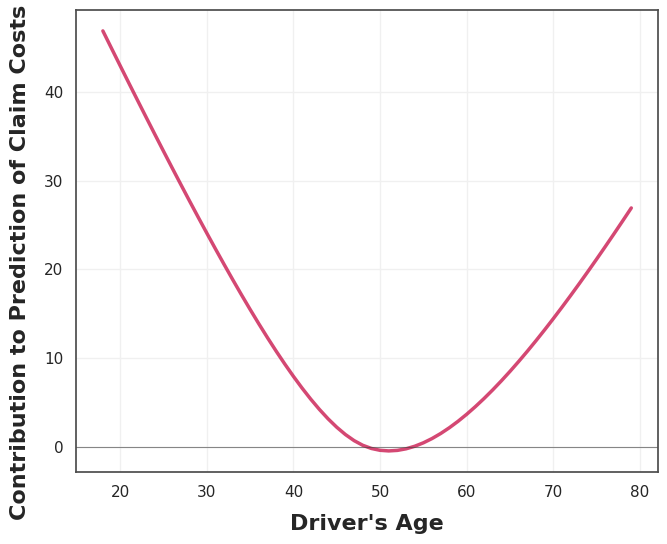

In [9]:
age_data = next(item for item in data_dict if item["name"] == "age")

x_raw, y_raw = model._get_pred_of_i(1)

x_accident_mean = scaler.mean_[1]
x_accident_std = scaler.scale_[1]  

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std #+ y_mean

import matplotlib.ticker as mticker

# Applying Seaborn styling
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    color = sns.color_palette("rocket_r", n_colors=1)[0]

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Plot the line with reference styling
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, label="Effect of Accidents on Claim Cost")

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Driver's Age", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')
    #ax.set_title("Age Effect", fontsize=22, fontweight="bold", pad=15)

    # Korrekte Antwort hervorheben (bei x=4, y=279€)
    ax.scatter(70, 14.5, color=highlight_color, s=100, zorder=3, edgecolor="black", label="Correct Value (14€)")  # Punkt hervorheben
    ax.axhline(y=14.5, color=highlight_color, linestyle="--", linewidth=1.5, alpha=0.7)  # Horizontale Linie

    # Erklärung direkt in den Plot schreiben
    ax.text(69, 15.5, "Correct Value: 14€", fontsize=16, color=highlight_color, fontweight="bold", ha="right")

    # Customize ticks and grid
    ax.tick_params(axis='x', labelrotation=0, labelsize=16)  # Ensure no rotation
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Set Y-axis limits
    ax.set_ylim(-2, 52)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Add legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=12, frameon=True, shadow=False, fancybox=True, borderpad=1)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


In [ ]:
age_data = next(item for item in data_dict if item["name"] == "age")

x_raw, y_raw = model._get_pred_of_i(1)

x_accident_mean = scaler.mean_[1]
x_accident_std = scaler.scale_[1]  

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std #+ y_mean

import matplotlib.ticker as mticker

# Applying Seaborn styling
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    color = sns.color_palette("rocket_r", n_colors=1)[0]

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Plot the line with reference styling
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, label="Effect of Accidents on Claim Cost")

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Driver's Age", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')
    #ax.set_title("Age Effect", fontsize=22, fontweight="bold", pad=15)

    # Customize ticks and grid
    ax.tick_params(axis='x', labelrotation=0, labelsize=16)  # Ensure no rotation
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Set Y-axis limits
    ax.set_ylim(-2, 52)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Add legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=12, frameon=True, shadow=False, fancybox=True, borderpad=1)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


tensor(70.)

In [10]:
y_rescaled[52]

tensor(14.4327)

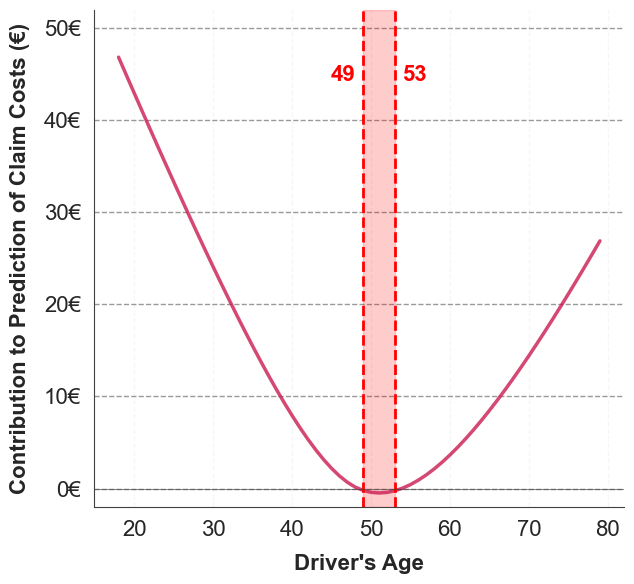

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.ticker as mticker

# Extracting data
age_data = next(item for item in data_dict if item["name"] == "age")

x_raw, y_raw = model._get_pred_of_i(1)

x_accident_mean = scaler.mean_[1]
x_accident_std = scaler.scale_[1]  

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std  # + y_mean

# Markierungen für den Bereich mit der niedrigsten Claim Cost Contribution
min_age_start = 49
min_age_end = 53

# Plot erstellen
with sns.axes_style("whitegrid", {"grid.color": "#f0f0f0", "axes.edgecolor": "0.3", "axes.linewidth": 1}):
    sns.set_context("notebook", font_scale=1)

    color = sns.color_palette("rocket_r", n_colors=1)[0]

    fig, ax = plt.subplots(1, 1, figsize=(6.5, 6), dpi=100)
    fig.patch.set_alpha(0)  # Hintergrund transparent

    # **Ganzen Bereich zwischen 49 und 53 leicht rot einfärben**
    ax.axvspan(min_age_start, min_age_end, color="red", alpha=0.2)

    # Plot der Kurve
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, label="Effect of Age on Claim Cost")

    # **Rote vertikale Linien bei 49 und 53**
    ax.axvline(x=min_age_start, color="red", linestyle="--", linewidth=2)
    ax.axvline(x=min_age_end, color="red", linestyle="--", linewidth=2)

    # **Labels für 49 und 53**
    ax.text(min_age_start-2.5, ax.get_ylim()[1] - 5, "49", color="red", fontsize=16, fontweight="semibold", ha="center")
    ax.text(min_age_end+2.5, ax.get_ylim()[1] - 5, "53", color="red", fontsize=16, fontweight="semibold", ha="center")

    # Horizontale Referenzlinie
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Achsenbeschriftungen
    ax.set_xlabel("Driver's Age", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')

    # Achsenticks und Raster
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Y-Achse formatieren
    ax.set_ylim(-2, 52)
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Spines anpassen
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Layout anpassen
    sns.despine(left=False, bottom=False)
    plt.tight_layout()
    plt.show()


### 4.1.3 Mileage

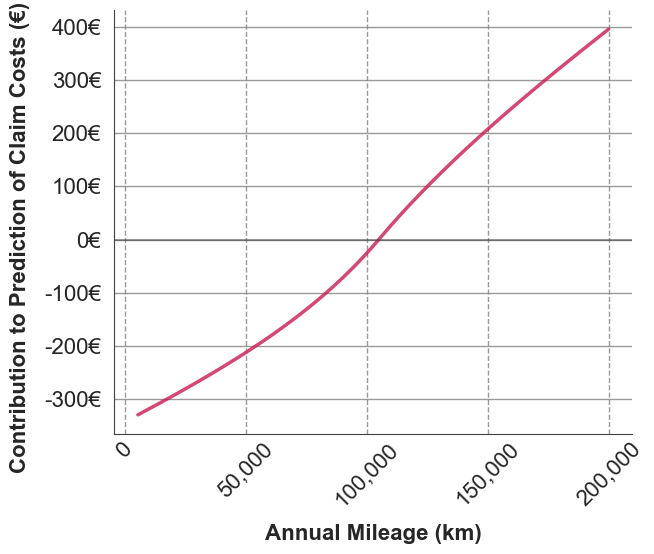

In [12]:
age_data = next(item for item in data_dict if item["name"] == "mileage")

x_raw, y_raw = model._get_pred_of_i(2)
# x_raw = age_data["x"]
# y_raw = age_data["y"]

x_accident_mean = scaler.mean_[2]  # Assuming similar naming convention
x_accident_std = scaler.scale_[2]  # Assuming similar naming convention

# Rescaling x and y
x_rescaled = x_raw * x_accident_std + x_accident_mean
y_rescaled = y_raw * y_std #+ y_mean

import matplotlib.ticker as mticker

# Applying Seaborn styling
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    color = sns.color_palette("rocket_r", n_colors=1)[0]

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Plot the line with reference styling
    ax.plot(x_rescaled, y_rescaled, linewidth=2.5, color=color, alpha=0.8, label="Effect of Accidents on Claim Cost")





    # Set labels and title
    ax.set_xlabel("Annual Mileage (km)", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)     ", fontsize=16, labelpad=10, fontweight='semibold')
    #ax.set_title("Mileage Effect", fontsize=22, fontweight="bold", pad=15)

    # Customize ticks and grid
    ax.tick_params(axis='x', labelrotation=45, labelsize=16, direction='in', length=6, width=1.2)  # Rotate and add tick marks
    ax.tick_params(axis='y', labelsize=16)
    ax.grid(visible=True, which='major', axis='both', linestyle='--', alpha=0.6)

    # Set Y-axis limits
    #ax.set_ylim(600, 1300)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x)}€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='-', alpha=0.8, color="gray")
    ax.xaxis.grid(True, linestyle='--', alpha=0.8, color="gray")
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}"))
    ax.tick_params(axis='x', which='minor', length=4, width=1, color='gray')
    
    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=1.2, alpha=0.6)


    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Add legend
    #ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), fontsize=12, frameon=True, shadow=False, fancybox=True, borderpad=1)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


In [ ]:
-25.2609

In [13]:
# return index of x_rescaled = 100000
np.abs(x_rescaled - 100000).argmin()

tensor(399)

In [14]:
y_rescaled[np.abs(x_rescaled - 100000).argmin()]

tensor(-25.2609)

### 4.1.4 Car type

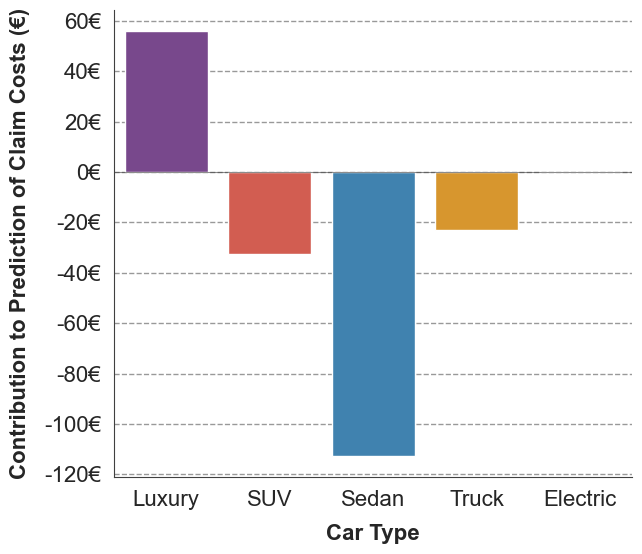

In [15]:
import pandas as pd

# Extracting 'carType' data
car_type_data = next(item for item in data_dict if item["name"] == "carType")

# Extracting values
categories = car_type_data["x"]
y_values = car_type_data["y"]

# Rescaling y-values
y_rescaled = np.array(y_values) * y_std #+ y_mean

# Creating DataFrame for plotting
df_car_type = pd.DataFrame({"Car Type": categories, "Contribution to Claim Cost (€)": y_rescaled})

# Plotting the Barplot
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    category_colors = {
        "Luxury": "#7D3C98",   # Dunkles Violett
        "SUV": "#E74C3C",      # Kräftiges Rot
        "Sedan": "#2E86C1",    # Sattes Blau
        "Truck": "#F39C12",    # Warmes Orange
        "Electric": "#27AE60"  # Frisches Grün
    }
    #color = sns.color_palette("rocket_r", n_colors=len(categories))

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Create Barplot
    sns.barplot(x="Car Type", y="Contribution to Claim Cost (€)", hue="Car Type", data=df_car_type, palette=category_colors, ax=ax, legend=False)

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Car Type", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')
    #ax.set_title("Car Type Effect", fontsize=22, fontweight="bold", pad=15)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".") + "€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")
    ax.yaxis.set_major_locator(MultipleLocator(20))
    #ax.set_ylim(-125, 75)

    ax.tick_params(axis='x', labelsize=16)  # Rotate and add tick marks
    ax.tick_params(axis='y', labelsize=16)

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


In [16]:
y_rescaled

array([  55.90320975,  -32.59677098, -112.58766095,  -23.07600929,
          0.        ])

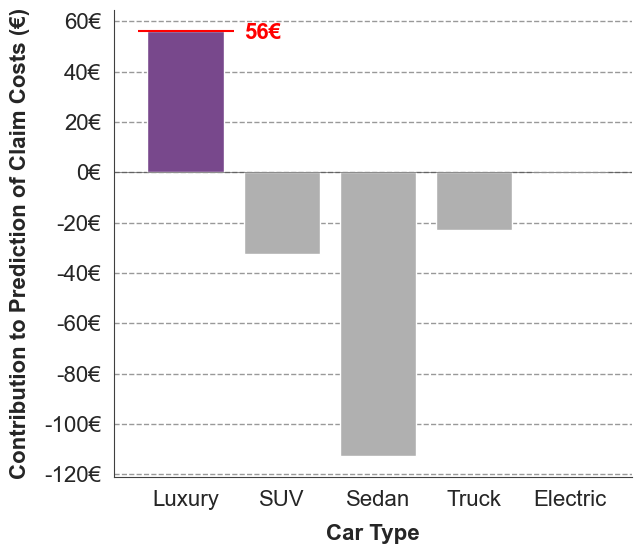

In [18]:
import pandas as pd

# Extracting 'carType' data
car_type_data = next(item for item in data_dict if item["name"] == "carType")

# Extracting values
categories = car_type_data["x"]
y_values = car_type_data["y"]

# Rescaling y-values
y_rescaled = np.array(y_values) * y_std #+ y_mean

# Creating DataFrame for plotting
df_car_type = pd.DataFrame({"Car Type": categories, "Contribution to Claim Cost (€)": y_rescaled})

# Plotting the Barplot
with sns.axes_style("whitegrid", {
    "grid.color": "#f0f0f0",
    "axes.edgecolor": "0.3",
    "axes.linewidth": 1
}):
    sns.set_context("notebook", font_scale=1)

    # Define colors matching the reference style
    category_colors = {
        "Luxury": "#7D3C98",   # Dunkles Violett
        "SUV": "#B0B0B0",      # Kräftiges Rot
        "Sedan": "#B0B0B0",    # Sattes Blau
        "Truck": "#B0B0B0",    # Warmes Orange
        "Electric": "#B0B0B0"  # Frisches Grün
    }
    #color = sns.color_palette("rocket_r", n_colors=len(categories))

    # Create figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=100)
    fig.patch.set_alpha(0)  # Transparent background

    # Create Barplot
    sns.barplot(x="Car Type", y="Contribution to Claim Cost (€)", hue="Car Type", data=df_car_type, palette=category_colors, ax=ax, legend=False)

    # Add horizontal reference line
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Set labels and title
    ax.set_xlabel("Car Type", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')
    #ax.set_title("Car Type Effect", fontsize=22, fontweight="bold", pad=15)

    # Format Y-axis with € symbol
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".") + "€"))

    # Add horizontal grid lines for easier reading
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")
    ax.yaxis.set_major_locator(MultipleLocator(20))
    #ax.set_ylim(-125, 75)

    ax.text(0.8, 53, "56€", ha="center", fontsize=16, fontweight="bold", color="red")
    ax.hlines(y=56, xmin=-0.5, xmax=0.5, color="red", linewidth=1.5)


    ax.tick_params(axis='x', labelsize=16)  # Rotate and add tick marks
    ax.tick_params(axis='y', labelsize=16)

    # Customize spines
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Remove top and right spines
    sns.despine(left=False, bottom=False)

    # Adjust layout for better readability
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.subplots_adjust(right=0.8)

    # Show plot
    plt.show()


/var/folders/82/kbvzpwhd50j91vkgzn8h3gnr0000gn/T/ipykernel_1834/664042934.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(


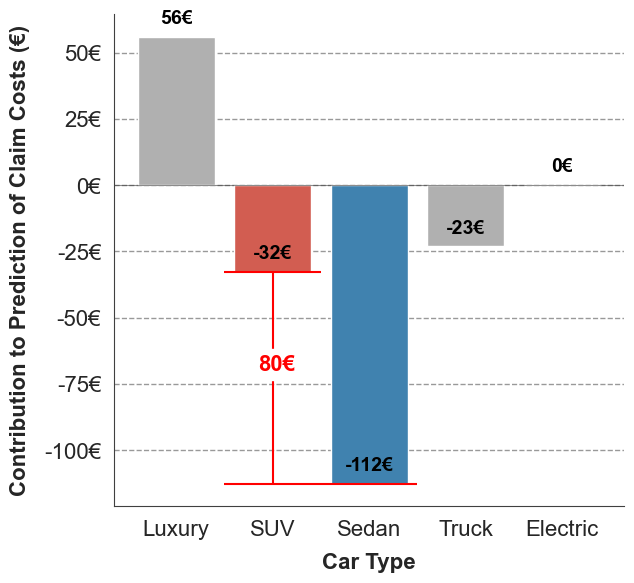

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

# Extracting 'carType' data
car_type_data = next(item for item in data_dict if item["name"] == "carType")

# Extracting values
categories = car_type_data["x"]
y_values = car_type_data["y"]

# Rescaling y-values
y_rescaled = np.array(y_values) * y_std  # + y_mean

# first value in rescaled is 56
y_rescaled[0] = 56

# Creating DataFrame for plotting
df_car_type = pd.DataFrame({"Car Type": categories, "Contribution to Claim Cost (€)": y_rescaled})

# Define colors: Sedan & SUV stay colored, others turn gray
highlight_colors = {
    "Sedan": "#2E86C1",  # Blau
    "SUV": "#E74C3C",    # Rot
}
default_gray = "#B0B0B0"  # Grauton für nicht relevante Balken

df_car_type["Color"] = df_car_type["Car Type"].apply(lambda x: highlight_colors.get(x, default_gray))

# Werte für SUV und Sedan extrahieren
y_sedan = df_car_type.loc[df_car_type["Car Type"] == "Sedan", "Contribution to Claim Cost (€)"].iloc[0]
y_suv = df_car_type.loc[df_car_type["Car Type"] == "SUV", "Contribution to Claim Cost (€)"].iloc[0]

# Berechnung der Differenz
diff_value = 80

# Plot erstellen
with sns.axes_style("whitegrid", {"grid.color": "#f0f0f0", "axes.edgecolor": "0.3", "axes.linewidth": 1}):
    fig, ax = plt.subplots(figsize=(6.5, 6), dpi=100)
    fig.patch.set_alpha(0)  # Hintergrund transparent

    # Balkendiagramm zeichnen
    bars = sns.barplot(
        x="Car Type",
        y="Contribution to Claim Cost (€)",
        data=df_car_type,
        palette=df_car_type["Color"].tolist(),  # .tolist() macht Series zu Liste
        ax=ax,
        legend=False
    )

    # Horizontale Referenzlinie
    ax.axhline(y=0, color="#404040", linestyle="-", linewidth=0.8, alpha=0.6)

    # Werte direkt über den Balken anzeigen
    for bar, value in zip(bars.patches, df_car_type["Contribution to Claim Cost (€)"]):
        ax.text(bar.get_x() + bar.get_width() / 2, value + 5, f"{int(value)}€",
                ha="center", fontsize=14, fontweight="bold", color="black")

    # **Senkrechte Linie + Horizontale Verbindungslinien**
    x_sedan = df_car_type.index[df_car_type["Car Type"] == "Sedan"][0]
    x_suv = df_car_type.index[df_car_type["Car Type"] == "SUV"][0]

    # Vertikale Linie zwischen SUV und Sedan
    ax.vlines(x=1, ymin=y_sedan, ymax=y_suv, color="red", linestyle="-", linewidth=1.5)

    # Horizontale Verbindungslinien an den Enden
    ax.hlines(y=y_sedan, xmin=0.5, xmax=2.5, color="red", linewidth=1.5)
    ax.hlines(y=y_suv, xmin=0.5, xmax=1.5, color="red", linewidth=1.5)

    # Differenzwert in der Mitte platzieren
    ax.text(0.85, (y_sedan+10 + y_suv) / 2, f"{diff_value}€", 
            fontsize=16, fontweight="bold", color="red", ha="left", va="center", backgroundcolor="white")

    # Achsentitel und Labels
    ax.set_xlabel("Car Type", fontsize=16, labelpad=10, fontweight='semibold')
    ax.set_ylabel("Contribution to Prediction of Claim Costs (€)", fontsize=16, labelpad=10, fontweight='semibold')

    # Y-Achse formatieren
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".") + "€"))
    ax.yaxis.grid(True, linestyle='--', alpha=0.8, color="gray")

    # Achsenticks anpassen
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # Spines anpassen
    ax.spines["bottom"].set_color("#404040")
    ax.spines["left"].set_color("#404040")
    ax.spines["bottom"].set_linewidth(0.8)
    ax.spines["left"].set_linewidth(0.8)

    # Layout anpassen
    sns.despine(left=False, bottom=False)
    plt.tight_layout()
    plt.show()


## 4.2 Heatmap Plot

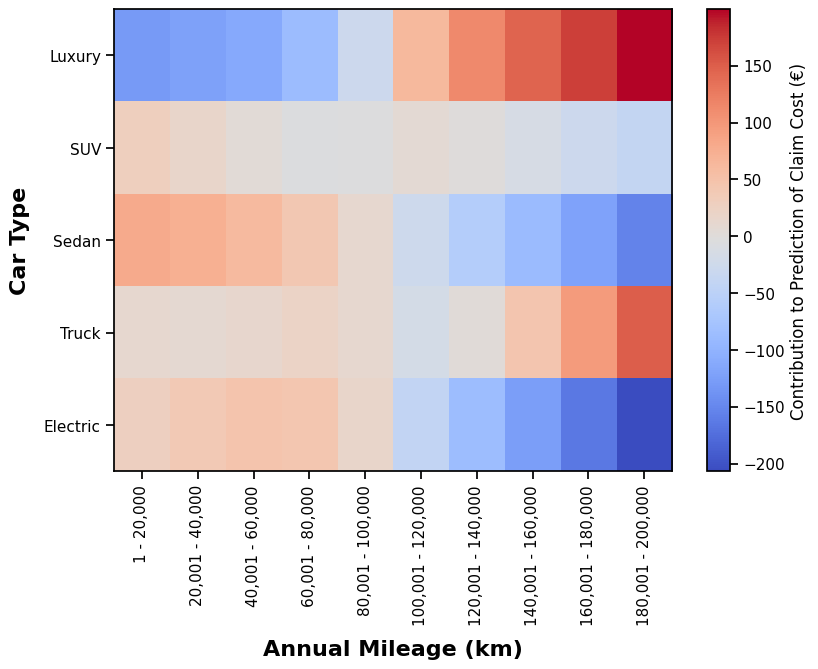

In [93]:
shape_fun = model.get_it_shape_functions_as_dict(scaler=scaler, y_mean=0, y_std=y_std)
data = shape_fun
unique_x_values = sorted(set([x for category in shape_fun for x in category['x']]))

# devide x-Values in bins
num_bins = 10
#bins = np.linspace(min(unique_x_values), max(unique_x_values), num_bins + 1)
bins = np.linspace(0, 200000, num_bins + 1)

#categories = [category['name'] for category in shape_fun]
categories = ['Luxury', 'SUV', 'Sedan', 'Truck', 'Electric']

# create matrix for binned data
heatmap_data_binned = np.full((len(categories), num_bins), np.nan)
for i, category in enumerate(data):
    for x_val, y_val in zip(category['x'], category['y']): # category['y_incl_univ']: y values include univariate effects
        bin_index = np.digitize(x_val, bins) - 1  # Bin-Index bestimmen
        if 0 <= bin_index < num_bins:
            if np.isnan(heatmap_data_binned[i, bin_index]):
                heatmap_data_binned[i, bin_index] = y_val
            else:
                heatmap_data_binned[i, bin_index] = (heatmap_data_binned[i, bin_index] + y_val) / 2

bin_labels = [(bins[i] + bins[i + 1]) / 2 for i in range(num_bins)]

heatmap_data_binned = np.vstack([heatmap_data_binned[1:], heatmap_data_binned[0]])


df_heatmap_binned = pd.DataFrame(heatmap_data_binned, index=categories, columns=bin_labels)


plt.figure(figsize=(9, 6))
plt.imshow(heatmap_data_binned, aspect="auto", cmap="coolwarm", interpolation="nearest")
plt.xticks(
    ticks=np.arange(num_bins),
    labels=[f"{int(val-9999):,} - {int(round(val+10000, -3)):,}" for val in bin_labels], 
    rotation=90
)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.colorbar(label="Contribution to Prediction of Claim Cost (€)")
#plt.title("Interaction Effect: Mileage x Car Type", fontsize=22, fontweight="bold", pad=15)
plt.xlabel("Annual Mileage (km)", fontsize=16, labelpad=10, fontweight='semibold')
plt.ylabel("Car Type", fontsize=16, labelpad=10, fontweight='semibold')

plt.show()

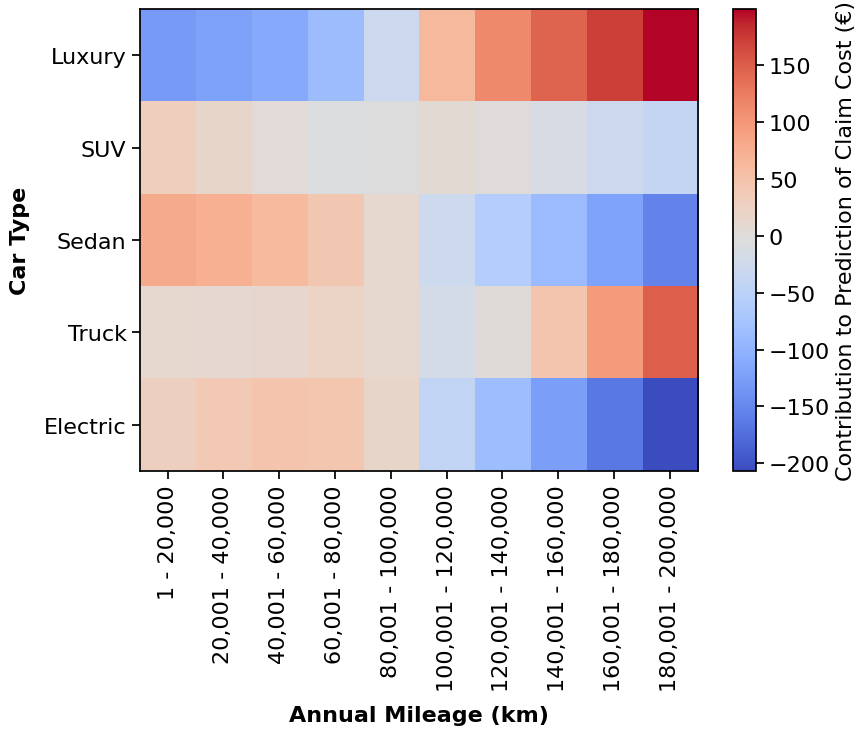

In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hintergrund freistellen
plt.figure(figsize=(9, 6), facecolor='none')

# Heatmap zeichnen
plt.imshow(heatmap_data_binned, aspect="auto", cmap="coolwarm", interpolation="nearest")

# X-Ticks mit größerer Schrift
plt.xticks(
    ticks=np.arange(num_bins),
    labels=[f"{int(val-9999):,} - {int(round(val+10000, -3)):,}" for val in bin_labels], 
    rotation=90,
    fontsize=16  # Größere Schrift
)

# Y-Ticks mit größerer Schrift
plt.yticks(ticks=np.arange(len(categories)), labels=categories, fontsize=16)

# Farbskala (Colorbar) größer machen
cbar = plt.colorbar(label="Contribution to Prediction of Claim Cost (€)")
cbar.ax.yaxis.label.set_size(16)
cbar.ax.tick_params(labelsize=16)  # Vergrößert die Zahlen der Farbskala

# Werte nur in der letzten Spalte schreiben
for i in range(heatmap_data_binned.shape[0]):
    j = num_bins - 1  # Letzte Spalte
    text_color = "white" if abs(heatmap_data_binned[i, j]) > 50 else "black"
    ax.text(j, i, int(heatmap_data_binned[i, j]), ha="center", va="center", color=text_color, fontsize=14, fontweight='bold')



# Hintergrund des Plots entfernen
plt.gca().set_facecolor('none')  # Hintergrund des Achsenbereichs transparent machen

# Achsentitel mit größerer Schrift
plt.xlabel("Annual Mileage (km)", fontsize=16, labelpad=10, fontweight='semibold')
plt.ylabel("Car Type", fontsize=16, labelpad=10, fontweight='semibold')

plt.show()


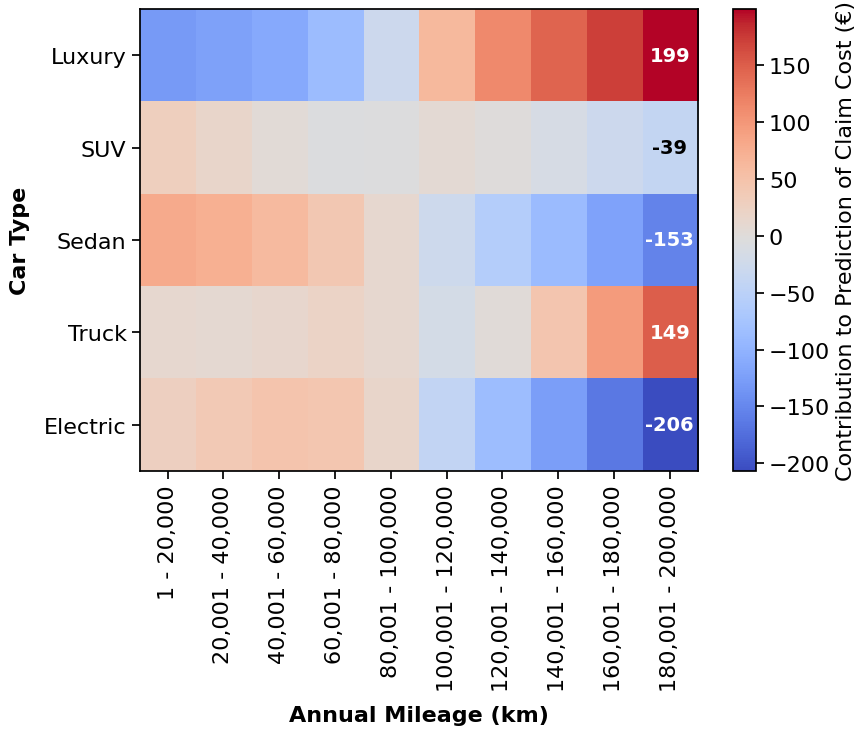

In [195]:
import numpy as np
import matplotlib.pyplot as plt

num_bins = heatmap_data_binned.shape[1]
categories = ["Luxury", "SUV", "Sedan", "Truck", "Electric"]

# Plot erstellen
fig, ax = plt.subplots(figsize=(9, 6))
cax = ax.imshow(heatmap_data_binned, aspect="auto", cmap="coolwarm", interpolation="nearest")

# X- und Y-Ticks formatieren
xtick_labels = [f"{i*10:,} - {(i+1)*10:,}" for i in range(num_bins)]
xtick_fontweights = ['bold' if i == num_bins - 1 else 'normal' for i in range(num_bins)]

for i, label in enumerate(ax.get_xticklabels()):
    label.set_fontsize(14)
    label.set_weight(xtick_fontweights[i])

plt.xticks(
    ticks=np.arange(num_bins),
    labels=[f"{int(val-9999):,} - {int(round(val+10000, -3)):,}" for val in bin_labels], 
    rotation=90,
    fontsize=16  # Größere Schrift
)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, fontsize=16)

# Farbskala hinzufügen
cbar = plt.colorbar(cax, label="Contribution to Prediction of Claim Cost (€)")
cbar.ax.yaxis.label.set_size(16)
cbar.ax.tick_params(labelsize=16)

# Werte nur in der letzten Spalte schreiben
for i in range(heatmap_data_binned.shape[0]):
    j = num_bins - 1  # Letzte Spalte
    text_color = "white" if abs(heatmap_data_binned[i, j]) > 50 else "black"
    ax.text(j, i, int(heatmap_data_binned[i, j]), ha="center", va="center", color=text_color, fontsize=14, fontweight='bold')

plt.gca().set_facecolor('none')  # Hintergrund des Achsenbereichs transparent machen

# Achsentitel formatieren
plt.xlabel("Annual Mileage (km)", fontsize=16, fontweight='bold', labelpad=10)
plt.ylabel("Car Type", fontsize=16, fontweight='bold', labelpad=10)

plt.show()


## 4.3 Lineplot Univariate

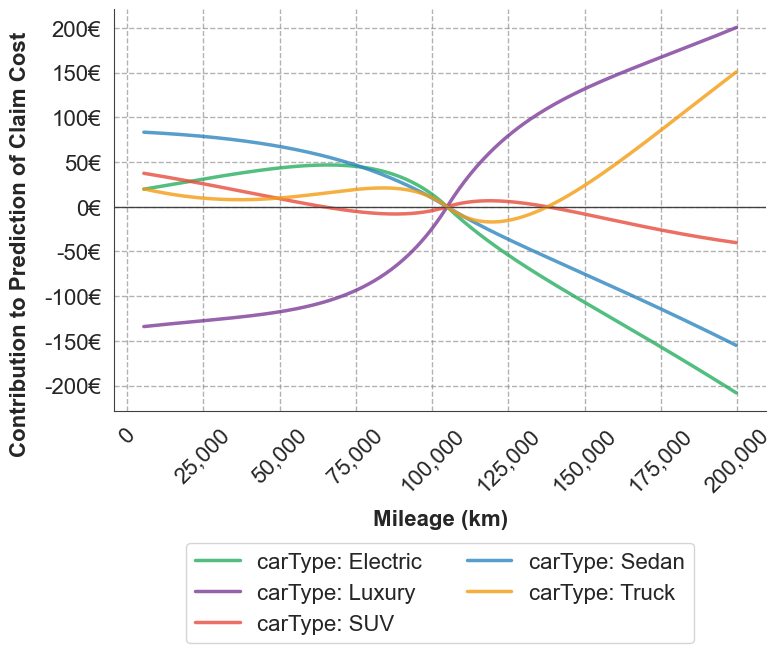

In [89]:
model.plot_it(scaler=scaler, y_mean=0, y_std=y_std, include_univariate=False)

In [103]:
#data[1]['y']
np.abs(data[1]['y'] - 10000).argmin()

TypeError: unsupported operand type(s) for -: 'list' and 'int'

In [128]:
data[4]['y']

[20.04338264465332,
 19.547147750854492,
 19.060977935791016,
 18.584918975830078,
 18.118982315063477,
 17.663227081298828,
 17.217660903930664,
 16.782297134399414,
 16.357158660888672,
 15.942343711853027,
 15.537790298461914,
 15.143588066101074,
 14.759779930114746,
 14.386320114135742,
 14.023223876953125,
 13.670607566833496,
 13.328422546386719,
 12.996709823608398,
 12.675466537475586,
 12.364720344543457,
 12.064473152160645,
 11.774750709533691,
 11.495590209960938,
 11.226972579956055,
 10.96888256072998,
 10.721342086791992,
 10.484357833862305,
 10.257969856262207,
 10.042094230651855,
 9.836816787719727,
 9.642080307006836,
 9.457883834838867,
 9.284252166748047,
 9.12111759185791,
 8.968482971191406,
 8.826356887817383,
 8.69472885131836,
 8.573526382446289,
 8.462747573852539,
 8.362384796142578,
 8.272357940673828,
 8.192672729492188,
 8.123318672180176,
 8.064170837402344,
 8.015240669250488,
 7.976463794708252,
 7.947798252105713,
 7.929184913635254,
 7.920551776885

In [ ]:
data[3]['y_incl_univ']

[-358.8490905761719,
 -357.3950500488281,
 -355.9406433105469,
 -354.4859313964844,
 -353.0308837890625,
 -351.5755615234375,
 -350.1197204589844,
 -348.66357421875,
 -347.20721435546875,
 -345.7503662109375,
 -344.2931823730469,
 -342.8356628417969,
 -341.37762451171875,
 -339.9192810058594,
 -338.4604797363281,
 -337.00128173828125,
 -335.5415344238281,
 -334.0813293457031,
 -332.62091064453125,
 -331.15966796875,
 -329.697998046875,
 -328.23614501953125,
 -326.77349853515625,
 -325.3101501464844,
 -323.84661865234375,
 -322.3822937011719,
 -320.9173583984375,
 -319.4520263671875,
 -317.9859619140625,
 -316.51904296875,
 -315.0519104003906,
 -313.5838623046875,
 -312.11517333984375,
 -310.6457824707031,
 -309.1755065917969,
 -307.70477294921875,
 -306.2330627441406,
 -304.7606506347656,
 -303.2873229980469,
 -301.8133239746094,
 -300.3382873535156,
 -298.8625793457031,
 -297.3857421875,
 -295.9081115722656,
 -294.42938232421875,
 -292.94989013671875,
 -291.46923828125,
 -289.98770141

## 4.4 Lineplot Cumulative

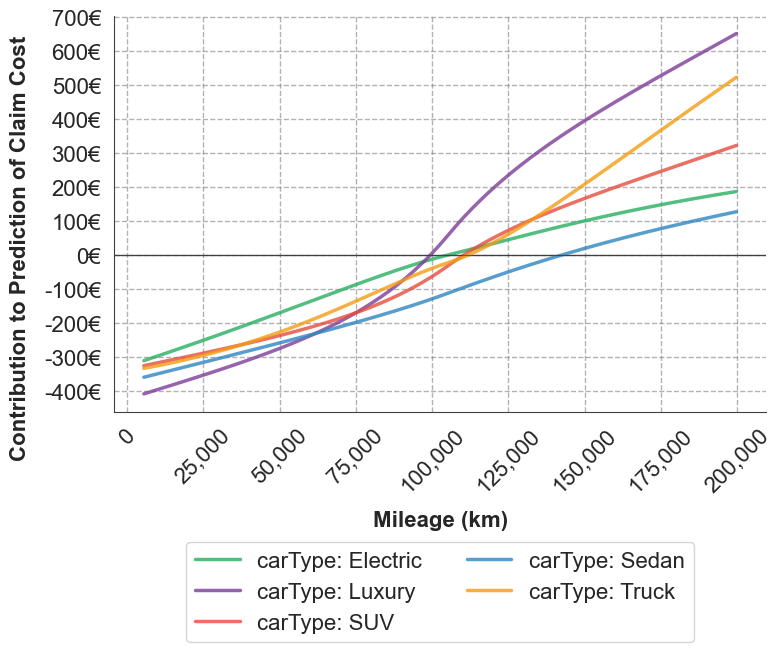

In [157]:
model.plot_it(scaler=scaler, y_mean=0, y_std=y_std, include_univariate=True)

In [158]:
data[1]['y_incl_univ']

[-407.75201416015625,
 -405.943115234375,
 -404.133544921875,
 -402.3230895996094,
 -400.51141357421875,
 -398.6988525390625,
 -396.8851318359375,
 -395.07012939453125,
 -393.2535095214844,
 -391.4360046386719,
 -389.6162109375,
 -387.7948303222656,
 -385.9716491699219,
 -384.14630126953125,
 -382.31890869140625,
 -380.48931884765625,
 -378.6572570800781,
 -376.82269287109375,
 -374.9851989746094,
 -373.14520263671875,
 -371.3022766113281,
 -369.4556884765625,
 -367.6060485839844,
 -365.7531433105469,
 -363.89666748046875,
 -362.03607177734375,
 -360.1717224121094,
 -358.3031921386719,
 -356.43035888671875,
 -354.5531311035156,
 -352.6711730957031,
 -350.7844543457031,
 -348.8924865722656,
 -346.9953918457031,
 -345.0927734375,
 -343.1844177246094,
 -341.2702331542969,
 -339.349853515625,
 -337.4232177734375,
 -335.4898376464844,
 -333.5498352050781,
 -331.6027526855469,
 -329.64849853515625,
 -327.6864318847656,
 -325.716796875,
 -323.7389221191406,
 -321.75274658203125,
 -319.7579956

# 5. Correct Answers

## Q1

In [140]:
x_raw, y_raw = model._get_pred_of_i(2)

x_mileage_mean = scaler.mean_[2]
x_mileage_std = scaler.scale_[2]

x_rescaled = x_raw * x_mileage_std + x_mileage_mean
y_rescaled = y_raw * y_std #+ y_mean

mil_eff = y_rescaled[np.abs(x_rescaled - 100000).argmin()] # y value at x = 100000

car_type_eff = (np.array(car_type_data["y"]) * y_std)[3]  # y value for Truck

int_eff = heatmap_data_binned[3][4]

mil_eff + car_type_eff + int_eff


tensor(-36.6659)

### Lineplot

In [141]:
int_eff = np.array(data[4]['y'])[np.abs(np.array(data[4]['x'])-100000).argmin()]

mil_eff + car_type_eff + int_eff

tensor(-37.6038)

### Cumulative

In [161]:
np.array(data[4]['y_incl_univ'])[np.abs(np.array(data[4]['x'])-100000).argmin()]

-39.354248046875

## Q2

### Heatmap

In [148]:
x_raw, y_raw = model._get_pred_of_i(2)

x_mileage_mean = scaler.mean_[2]
x_mileage_std = scaler.scale_[2]

x_rescaled = x_raw * x_mileage_std + x_mileage_mean
y_rescaled = y_raw * y_std #+ y_mean

mil_eff = y_rescaled[np.abs(x_rescaled - 50000).argmin()] # y value at x = 50000

car_type_eff = (np.array(car_type_data["y"]) * y_std)[0]  # y value for Luxury

int_eff = heatmap_data_binned[0][2]

mil_eff + car_type_eff + int_eff

tensor(-268.7758)

### Lineplot

In [ ]:
int_eff = np.array(data[1]['y'])[np.abs(np.array(data[1]['x'])-50000).argmin()]

mil_eff + car_type_eff + int_eff

tensor(-274.3683)

### Cumulative

In [162]:
np.array(data[1]['y_incl_univ'])[np.abs(np.array(data[1]['x'])-50000).argmin()]

-273.0528259277344

## Q3

In [152]:
x_raw, y_raw = model._get_pred_of_i(2)

x_mileage_mean = scaler.mean_[2]
x_mileage_std = scaler.scale_[2]

x_rescaled = x_raw * x_mileage_std + x_mileage_mean
y_rescaled = y_raw * y_std #+ y_mean

mil_eff = y_rescaled[np.abs(x_rescaled - 150000).argmin()] # y value at x = 150000

car_type_eff = (np.array(car_type_data["y"]) * y_std)[2]  # y value for Sedan

int_eff = heatmap_data_binned[2][7]

mil_eff + car_type_eff + int_eff

tensor(6.7507)

In [153]:
int_eff = np.array(data[3]['y'])[np.abs(np.array(data[3]['x'])-150000).argmin()]

mil_eff + car_type_eff + int_eff

tensor(20.7372)

In [163]:
np.array(data[3]['y_incl_univ'])[np.abs(np.array(data[3]['x'])-150000).argmin()]

19.48758888244629